In [26]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from pathlib import Path

https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632

In [7]:
annotation_file = Path("./birdclef-2022/train_metadata.csv")
dataframe = pd.read_csv(annotation_file)
dataframe.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg


## loading data

In [48]:
img_dir = Path("./spectograms/train_img/")

data_transforms = transforms.Compose([
  transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=img_dir, transform=data_transforms)

In [51]:
len(dataset) * 0.8, len(dataset)

(11881.6, 14852)

In [53]:
train_set, val_set = torch.utils.data.random_split(dataset, [11881, 2971], generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train_set, batch_size=1)
val_dataloader = DataLoader(val_set, batch_size=1)

Feature batch shape: torch.Size([1, 3, 224, 617])
Labels batch shape: torch.Size([1])


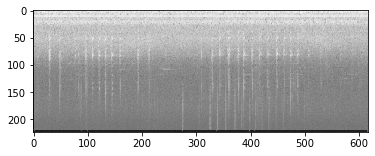

Label: 30


In [54]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.T.swapaxes(0,1), cmap="gray")
plt.show()
print(f"Label: {label}")

## Model architecture

In [27]:
import torch
import torch.nn.functional as F

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

In [30]:
X_train[0]

tensor([[8.9865e-03, 4.2636e-03, 5.1008e-05,  ..., 1.1000e-05, 2.0570e-03,
         8.0032e-03],
        [9.0097e-03, 4.2936e-03, 3.7561e-05,  ..., 1.2993e-05, 2.0744e-03,
         8.0402e-03],
        [9.0676e-03, 4.3042e-03, 5.1448e-05,  ..., 1.3919e-05, 2.1201e-03,
         8.0720e-03],
        ...,
        [2.1308e-03, 9.8159e-04, 6.5151e-05,  ..., 3.6590e-05, 1.5210e-04,
         5.9034e-04],
        [2.1655e-03, 1.0791e-03, 1.3939e-04,  ..., 2.4489e-05, 1.6248e-04,
         6.0643e-04],
        [2.2068e-03, 1.1434e-03, 6.5144e-05,  ..., 1.2710e-05, 2.1759e-04,
         6.4147e-04]])

In [29]:
class PatchEmbedding(nn.Module):
  def __init__(self,
    in_channels: int = 1,
    patch_size: int = 16,
    emb_size: int = 768):

    super().__init__()
    self.proj = nn.Sequential(
      nn.Conv2d(in_channels,
        emb_size,
        kernel_size = patch_size,
        stride = patch_size),
      Rearrange('b e (h) (w) -> b (h w) e'),
    )

    self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))

  def forward(self, x: Tensor) -> Tensor:
    b, _, _, _ = x.shape
    x = self.proj(x)
    cls_tokens = repeat(self.cls_token, '() n e -> b n e', b = b)
    x = torch.cat([cls_tokens, x], dim = 1)
    return x

PatchEmbedding()(X_train[0]).shape

ValueError: not enough values to unpack (expected 4, got 2)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(zip(X_train, y_train)):
        # zero the parameter gradients
        optimizer.zero_grad()

        inputs = inputs.reshape((1, 1025, 216))
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

In [ ]:
f1score = f1_score(y_test, np.round(preds), average="micro")
print(f1score)

In [ ]:
birdclef_dir = "/kaggle/input/birdclef-2022/"

with open(birdclef_dir + "scored_birds.json") as fp:
    scored_birds = json.load(fp)
    
print(scored_birds)

In [ ]:
def eval_test_file(filedir, filename):
    data = []
    audio, sample_rate = librosa.load(filedir + filename)
    num_chunks = math.ceil(len(audio) / (sample_rate * 5))
    for chunk in range(num_chunks):
        starting_second = chunk * 5
        ending_second = (chunk + 1) * 5
        audio_chunk = audio[(sample_rate * starting_second):(sample_rate * ending_second)]
        pred = round(xg_reg.predict([audio_chunk])[0])
        bird_id = le.inverse_transform([pred])[0]
        for bird in scored_birds:
            row_id = filename[:-4] + "_" + bird + "_" + str(ending_second)
            result = bird == bird_id
            data.append((row_id, result))
    return data

test_data_path = birdclef_dir + "test_soundscapes/"
out = eval_test_file(test_data_path, "soundscape_453028782.ogg")
out_df = pd.DataFrame(out, columns=["row_id","result"])
out_df.head()

In [ ]:
test_data_path = birdclef_dir + "test_soundscapes/"
filenames = sorted(os.listdir(test_data_path))
data = []
for filename in filenames:
    data += eval_test_file(test_data_path, filename)
test_df = pd.DataFrame(sorted(data), columns=['row_id', 'result'])
test_df.to_csv("submission.csv", index=False)